In [1]:
import numpy as np
from scipy.stats import norm, beta, ttest_ind
from tqdm import tqdm
from statsmodels.stats.power import tt_ind_solve_power, tt_solve_power
import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# 1. Конверсия

Эксперимент с конверсией с сайта. Есть старый дизайн и новый дизайн. Конверсия составляет 1%. Предположение, что при изменении дизайна конверсия увеличится до 1,3%. 

Провести стат тест. Определить минимально необходимый размер выборки и доверительный интервал.

## Частотный АВ-тест

### Статистическая значимость различий

In [51]:
# Конверсии в процентах для двух групп
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE1 = 1000
SIZE2 = 1200

# Создаем массивы для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE1)
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE2)

# Применяем двухвыборочный t-тест для сравнения средних
t_statistic, p_value = ttest_ind(data_control, data_experiment)

# Проверяем статистическую значимость на уровне 0.05
alpha = 0.05
if p_value < alpha:
    result = "статистически значимое различие"
else:
    result = "нет статистически значимого различия"

print(f"Результат A/B-теста: {result}")
print(f"p_value: {p_value:.4f}")
print(f'Учитывая, что H_0 верна, вероятность того, что мы получим наблюдаемый или \
еще более экстремальный исход, составляет не более {p_value:.4f} %.')

Результат A/B-теста: нет статистически значимого различия
p_value: 0.9737
Учитывая, что H_0 верна, вероятность того, что мы получим наблюдаемый или еще более экстремальный исход, составляет не более 0.9737 %.


### Минимальный размер выборки

Мы хотим оценить какой минимальный размер выборки нам нужен, что бы выловить наши различия, т.е что бы они стали статистически значимыми.

$$n = \frac{2(Z_{\alpha / 2} + Z_{\beta})^2 \sigma^2}{\delta^2}$$

$Z_{\alpha / 2}$ - критическое значение, соответствующее искомому уровню значимости $\alpha / 2$. Берется $\alpha / 2$ потому, что мы рассматриваем двусторонний тест. Значение $\alpha$ определяет уровень допустимости ошибки первого рода. Как правило $\alpha$ берется 0.05 для обычных исследовний и 0.01 для случая медицинских исследований или иных, где ошибка первого рода (отвергнута верная нулевая гипотеза) является критически важной.

$Z_\beta$ - критическое значение, соотвествующее заданному уровню статистической мощности. Значение $\beta$ определяет вероятность ошибки второго рода (принята неверная нулевая гипотеза). Как правило $\beta$ устанавливается на уровне 0.8 или 0.9.

$\sigma$ - стандартное отклонение

$\delta$ - размер эффекта, который необходимо выловить

In [3]:
p_experiment = 0.013
p_control = 0.01
effect_size = p_experiment - p_control
confidence_level = 0.95
power = 0.8

z_alpha = norm.ppf(1 - (1 - confidence_level) / 2)
z_beta = abs(norm.ppf(1 - power))

sample_size = ((2 * (z_alpha + z_beta)**2 * (p_experiment * (1 - p_experiment))) / effect_size**2)

# Округляем до целого значения
sample_size = int(sample_size) + 1

print(f"Минимальный размер выборки для каждой группы: {sample_size}")

Минимальный размер выборки для каждой группы: 22380


### Доверительный интервал

In [25]:
conversion_experiment = 0.013  # Конверсия в эксперименте
n_experiment = 2200  # Общее количество наблюдений в эксперименте

# Вычисляем стандартную ошибку для доли (конверсии)
std_err = np.sqrt(conversion_experiment * (1 - conversion_experiment) / n_experiment)

# Определение уровня доверия
confidence_level = 0.95

# Рассчитываем критическое значение Z-статистики для доверительного интервала
z_critical = norm.ppf(1 - (1 - confidence_level) / 2)

# Рассчитываем доверительный интервал методом Уилсона-Сандерсона
lower_bound = (conversion_experiment + z_critical**2 / (2 * n_experiment) - z_critical * std_err) / (1 + z_critical**2 / n_experiment)
upper_bound = (conversion_experiment + z_critical**2 / (2 * n_experiment) + z_critical * std_err) / (1 + z_critical**2 / n_experiment)

print(f"Доверительный интервал: [{lower_bound:.4f}, {upper_bound:.4f}]")
print(f'Ожидаемая конверсия {lower_bound:.4f} <- {conversion_experiment} -> {upper_bound:.4f}')

Доверительный интервал: [0.0091, 0.0186]
Ожидаемая конверсия 0.0091 <- 0.013 -> 0.0186


In [26]:
conversion_experiment = 0.013  # Конверсия в эксперименте
n_experiment = 20000  # Общее количество наблюдений в эксперименте

# Вычисляем стандартную ошибку для доли (конверсии)
std_err = np.sqrt(conversion_experiment * (1 - conversion_experiment) / n_experiment)

# Определение уровня доверия
confidence_level = 0.95

# Рассчитываем критическое значение Z-статистики для доверительного интервала
z_critical = norm.ppf(1 - (1 - confidence_level) / 2)

# Рассчитываем доверительный интервал методом Уилсона-Сандерсона
lower_bound = (conversion_experiment + z_critical**2 / (2 * n_experiment) - z_critical * std_err) / (1 + z_critical**2 / n_experiment)
upper_bound = (conversion_experiment + z_critical**2 / (2 * n_experiment) + z_critical * std_err) / (1 + z_critical**2 / n_experiment)

print(f"Доверительный интервал: [{lower_bound:.4f}, {upper_bound:.4f}]")
print(f'Ожидаемая конверсия {lower_bound:.4f} <- {conversion_experiment} -> {upper_bound:.4f}')

Доверительный интервал: [0.0115, 0.0147]
Ожидаемая конверсия 0.0115 <- 0.013 -> 0.0147


## Байесовский АВ-тест

Мы хотим получить ответ на вопрос: с какой вероятностью конверсия эксперимента больше чем контрольной группы?

Будем искать ответ налагая априорное предположение на коэффициенты конвесрии в виде бета-распределения.

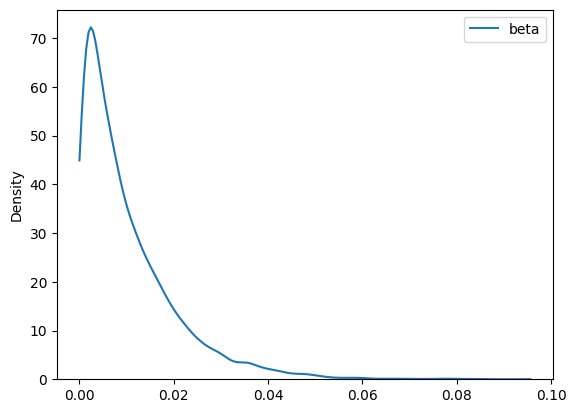

In [5]:
sample_beta = pm.Beta.dist(alpha=1, beta=99).random(size=10000)
sns.kdeplot(sample_beta, cut=0, label='beta');
plt.legend();

In [6]:
alpha=1
beta=99
E = alpha/(alpha+beta)
mode = (alpha-1) / (alpha + beta - 2)

print(f'E = {(E):.4f}')

E = 0.0100


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_rate, experiment_rate]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


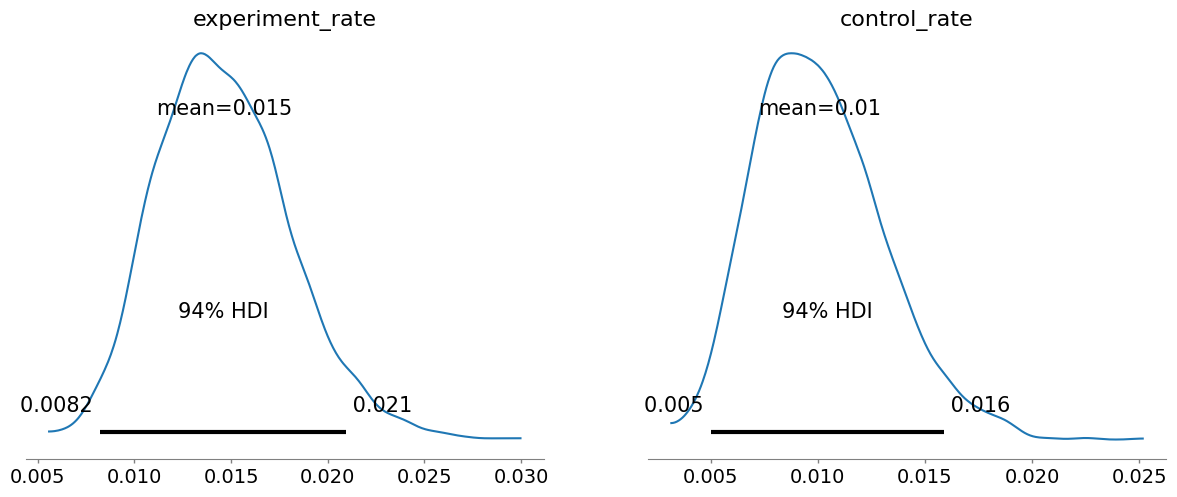

Общий объем выборки 2200
conversion_rate_control = 0.01  # Группа контроля 
conversion_rate_experiment = 0.013 # Группа эксперимента
Вероятность того, что экспериментальный дизайн лучше чем контрольный: 83.5%.


In [10]:
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE1 = 1000
SIZE2 = 1200

# Создаем массивы наблюдений для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE1)
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE2)

with pm.Model():
    conversion_rate_experiment = pm.Beta('experiment_rate', 1, 99)
    conversion_rate_control = pm.Beta('control_rate', 1, 99)
    
    conversion_experiment_obs = pm.Bernoulli('experment_obs', conversion_rate_experiment, observed=data_experiment)
    conversion_control_obs = pm.Bernoulli('control_obs', conversion_rate_control, observed=data_control)
    
    trace = pm.sample(return_inferencedata=True)

az.plot_posterior(trace)
plt.show();

conversion_experiment_rate_samples = trace.posterior['experiment_rate'].values
conversion_control_rate_samples = trace.posterior['control_rate'].values

print(f'Общий объем выборки {SIZE1+SIZE2}')
print(f'conversion_rate_control = 0.01  # Группа контроля \n\
conversion_rate_experiment = 0.013 # Группа эксперимента')

print(f'Вероятность того, что экспериментальный дизайн лучше чем контрольный: \
{(conversion_experiment_rate_samples > conversion_control_rate_samples).mean():.1%}.')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_rate, experiment_rate]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


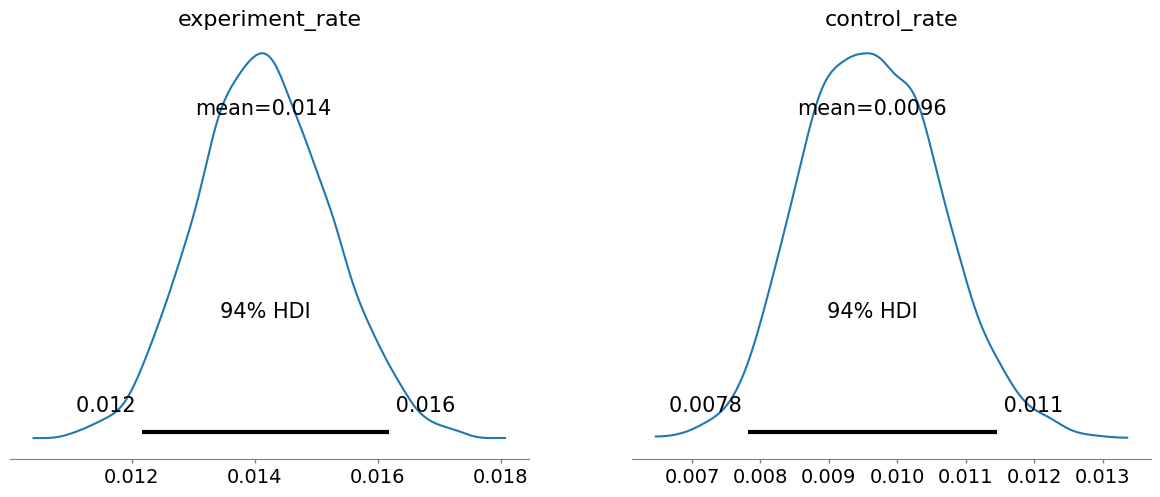

Общий объем выборки 22000
conversion_rate_control = 0.01  # Группа контроля 
conversion_rate_experiment = 0.013 # Группа эксперимента
Вероятность того, что экспериментальный дизайн лучше чем контрольный: 99.7%.


In [11]:
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE1 = 10000
SIZE2 = 12000

# Создаем массивы наблюдений для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE1)
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE2)

with pm.Model():
    conversion_rate_experiment = pm.Beta('experiment_rate', 1, 99)
    conversion_rate_control = pm.Beta('control_rate', 1, 99)
    
    conversion_experiment_obs = pm.Bernoulli('experment_obs', conversion_rate_experiment, observed=data_experiment)
    conversion_control_obs = pm.Bernoulli('control_obs', conversion_rate_control, observed=data_control)
    
    trace = pm.sample(return_inferencedata=True)

az.plot_posterior(trace)
plt.show();

conversion_experiment_rate_samples = trace.posterior['experiment_rate'].values
conversion_control_rate_samples = trace.posterior['control_rate'].values

print(f'Общий объем выборки {SIZE1+SIZE2}')
print(f'conversion_rate_control = 0.01  # Группа контроля \n\
conversion_rate_experiment = 0.013 # Группа эксперимента')

print(f'Вероятность того, что экспериментальный дизайн лучше чем контрольный: \
{(conversion_experiment_rate_samples > conversion_control_rate_samples).mean():.1%}.')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [control_rate, experiment_rate]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


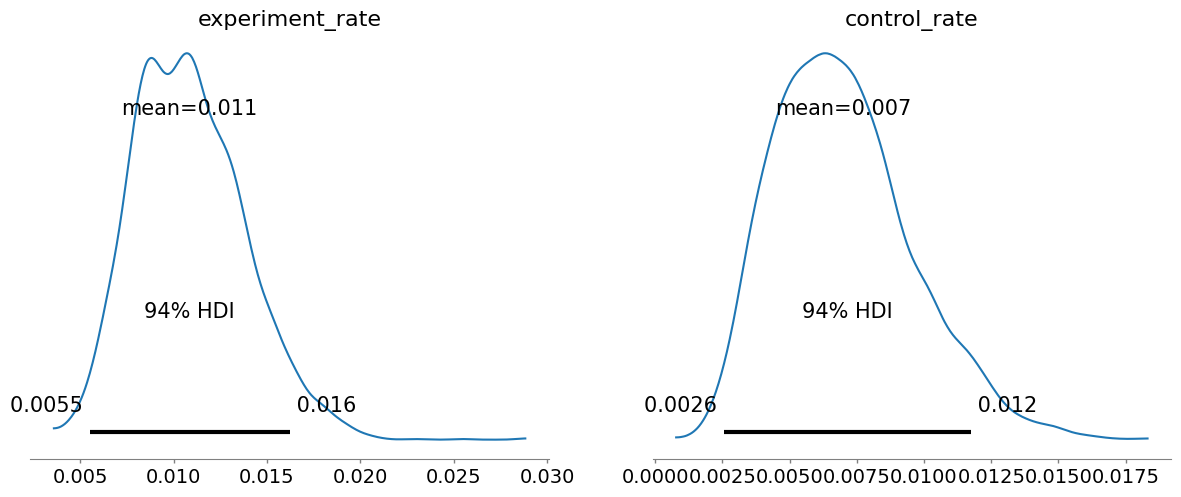

Общий объем выборки 2200
conversion_rate_control = 0.01  # Группа контроля 
conversion_rate_experiment = 0.013 # Группа эксперимента
Вероятность того, что экспериментальный дизайн лучше чем контрольный: 84.2%.


In [14]:
conversion_rate_control = 0.01  # Группа контроля
conversion_rate_experiment = 0.013  # Группа эксперимента

SIZE1 = 1000
SIZE2 = 1200

# Создаем массивы наблюдений для групп, где 1 представляет конверсию, а 0 - неконверсию
data_control = np.random.binomial(1, conversion_rate_control, size=SIZE1)
data_experiment = np.random.binomial(1, conversion_rate_experiment, size=SIZE2)

with pm.Model():
    conversion_rate_experiment = pm.Beta('experiment_rate', 1, 9)
    conversion_rate_control = pm.Beta('control_rate', 1, 9)
    
    conversion_experiment_obs = pm.Bernoulli('experment_obs', conversion_rate_experiment, observed=data_experiment)
    conversion_control_obs = pm.Bernoulli('control_obs', conversion_rate_control, observed=data_control)
    
    trace = pm.sample(return_inferencedata=True)

az.plot_posterior(trace)
plt.show();

conversion_experiment_rate_samples = trace.posterior['experiment_rate'].values
conversion_control_rate_samples = trace.posterior['control_rate'].values

print(f'Общий объем выборки {SIZE1+SIZE2}')
print(f'conversion_rate_control = 0.01  # Группа контроля \n\
conversion_rate_experiment = 0.013 # Группа эксперимента')

print(f'Вероятность того, что экспериментальный дизайн лучше чем контрольный: \
{(conversion_experiment_rate_samples > conversion_control_rate_samples).mean():.1%}.')

# Распределеные значения

Предположим наличие двух распределений с небольшим размером выборки
(https://habr.com/ru/articles/653363/)

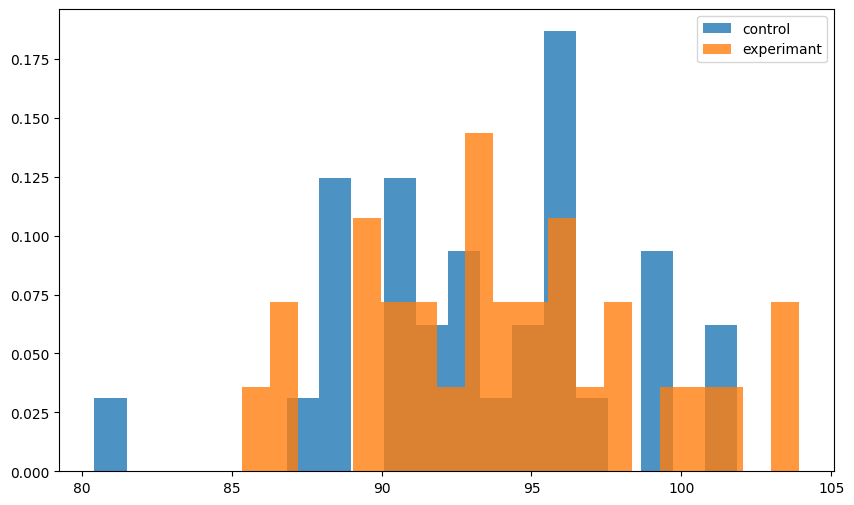

In [16]:
size=30
s_a = norm.rvs(loc=94, scale=4, size=size)
s_b = norm.rvs(loc=95, scale=4, size=size)
plt.figure(figsize=(10, 6))
plt.hist(s_a, density=True, bins=20, histtype='stepfilled', alpha=0.8, label='control')
plt.hist(s_b, density=True, bins=20, histtype='stepfilled', alpha=0.8, label='experimant')
plt.legend()
# plt.savefig('normal.jpg')
plt.show();

In [17]:
np.mean(s_a) - np.mean(s_b)

-0.7742367558655872

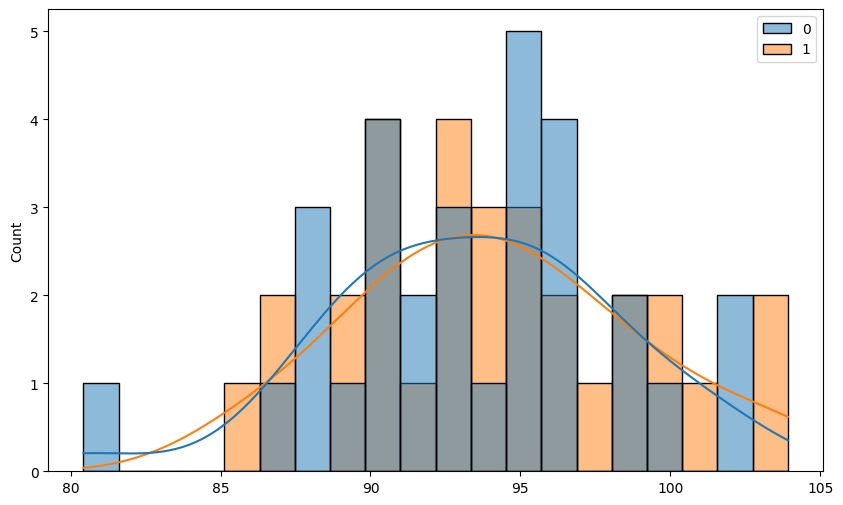

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot([s_a, s_b], bins=20, kde=True)
plt.show();

__Задача:__ провести АВ тест и найти статистическую значимость различий и оценить размер выборки.

In [19]:
# Размер выборки
size=30

# Получить две выборки значений размера (size)
s_a = norm.rvs(loc=94, scale=4, size=size)
s_b = norm.rvs(loc=95, scale=4, size=size)

# Выполняем t-тест для независимых выборок
t_statistic, p_value = ttest_ind(s_a, s_b)

# Выводим результаты
print("t-статистика:", t_statistic)
print("p-значение:", p_value)

# если p-значение меньше выбранного уровня значимости (например, 0.05), 
# можно сделать вывод о том, что средние значения в выборках различаются значимо. 
# Если p-значение больше уровня значимости, то различие не считается статистически значимым.

if p_value < 0.05:
    print('Средние различаются значимо')
else:
    print('Средние в среднем равны')

t-статистика: -1.105733296929625
p-значение: 0.27340751217478204
Средние в среднем равны


In [20]:
# Размер выборки
size=300

# Получить две выборки значений размера (size)
s_a = norm.rvs(loc=94, scale=4, size=size)
s_b = norm.rvs(loc=95, scale=4, size=size)

# Выполняем t-тест для независимых выборок
t_statistic, p_value = ttest_ind(s_a, s_b)

# Выводим результаты
print("t-статистика:", t_statistic)
print("p-значение:", p_value)

# если p-значение меньше выбранного уровня значимости (например, 0.05), 
# можно сделать вывод о том, что средние значения в выборках различаются значимо. 
# Если p-значение больше уровня значимости, то различие не считается статистически значимым.

if p_value < 0.05:
    print('Средние различаются значимо')
else:
    print('Средние в среднем равны')

t-статистика: -4.685853754666992
p-значение: 3.454873452064175e-06
Средние различаются значимо


А какой размер выборки необходим?

In [21]:
mu1 = 95
sigma1 = 4
mu2 = 94
sigma2 = 4
confidence_level = 0.95
power = 0.8

# Рассчитываем разницу между средними
mean_difference = mu1 - mu2

# Рассчитываем стандартную ошибку для разности средних
n = 1  # Начнем с минимального значения и будем увеличивать
standard_error_diff = np.sqrt((sigma1**2) / n + (sigma2**2) / n)

# Значения Z-статистики для заданного уровня доверия и мощности
z_alpha = norm.ppf(1 - (1 - confidence_level) / 2)
z_beta = abs(norm.ppf(1 - power))

# Эффектный размер
effect_size = abs(mean_difference) / standard_error_diff

# Расчет минимального размера выборки для каждой группы
sample_size = tt_ind_solve_power(
    effect_size=effect_size,
    alpha=1 - confidence_level,
    power=power,
    ratio=1,  # Предполагаем одинаковые размеры выборок
    alternative='two-sided'
)

# Округляем до целого значения
sample_size = int(np.ceil(sample_size))

print(f"Минимальный размер выборки для каждой группы: {sample_size}")

Минимальный размер выборки для каждой группы: 504


## Bayes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s_experiment_sigma, s_experiment_mu, s_control_sigma, s_control_mu]


/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/stureiko/miniforge3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


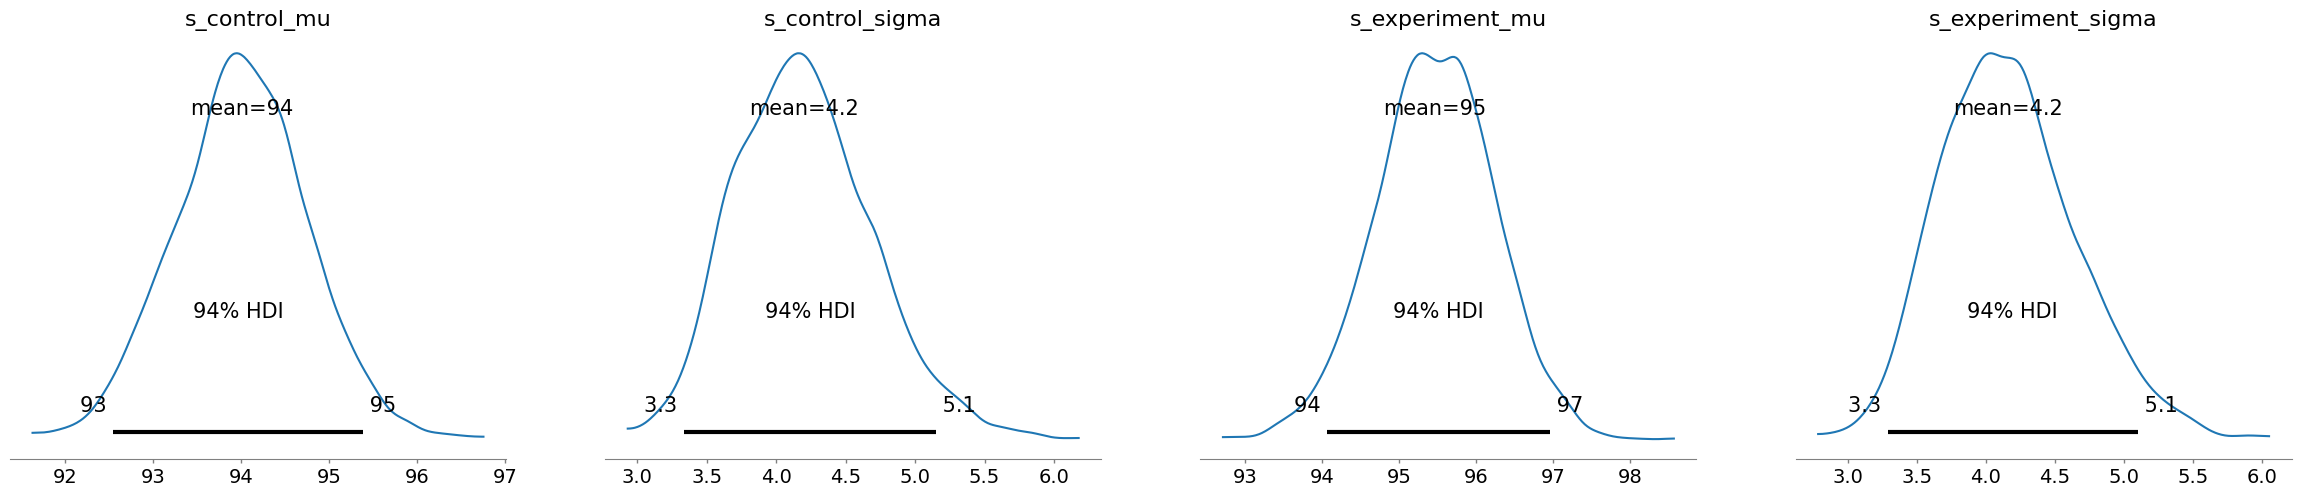

Общий объем выборки 60
conversion_rate_control = 0.01  # Группа контроля 
conversion_rate_experiment = 0.013 # Группа эксперимента
Вероятность того, что экспериментальный дизайн лучше чем контрольный: 91.0%.


In [22]:
s_control = 94  # Группа контроля
s_experiment = 95  # Группа эксперимента
s_sigma = 4

SIZE1 = 30
SIZE2 = 30

# Создаем массивы наблюдений для групп
data_control = norm.rvs(loc=s_control, scale=s_sigma, size=SIZE1)
data_experiment = norm.rvs(loc=s_experiment, scale=s_sigma, size=SIZE2)

with pm.Model():
    # prior
    s_control_mu = pm.Normal('s_control_mu', mu=s_control, sigma=s_sigma)
    s_control_sigma = pm.Normal('s_control_sigma', mu=s_sigma, sigma=1)
    s_experiment_mu = pm.Normal('s_experiment_mu', mu=s_control, sigma=s_sigma)
    s_experiment_sigma = pm.Normal('s_experiment_sigma', mu=s_sigma, sigma=1)
    
    # model
    s_control_obs = pm.Normal('s_control_obs', mu = s_control_mu, sigma = s_control_sigma, observed=data_control)
    s_experiment_obs = pm.Normal('s_experiment_obs', mu = s_experiment_mu, sigma = s_experiment_sigma, observed=data_experiment)
    
    # posterior
    trace = pm.sample(return_inferencedata=True)

az.plot_posterior(trace)
plt.show();

s_control_samples = trace.posterior['s_control_mu'].values
s_experiment_samples = trace.posterior['s_experiment_mu'].values


print(f'Общий объем выборки {SIZE1+SIZE2}')
print(f'conversion_rate_control = 0.01  # Группа контроля \n\
conversion_rate_experiment = 0.013 # Группа эксперимента')

print(f'Вероятность того, что экспериментальный дизайн лучше чем контрольный: \
{(s_experiment_samples > s_control_samples).mean():.1%}.')

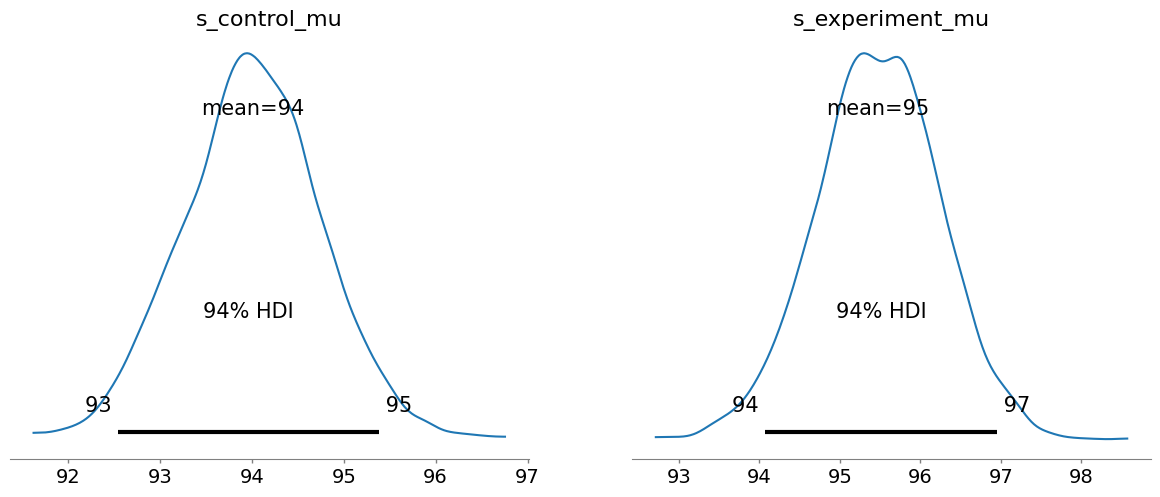

Общий объем выборки 60
conversion_rate_control = 0.01  # Группа контроля 
conversion_rate_experiment = 0.013 # Группа эксперимента
Вероятность того, что экспериментальный дизайн лучше чем контрольный: 91.0%.


In [23]:
az.plot_posterior(trace.posterior[['s_control_mu', 's_experiment_mu']])
plt.show();

s_control_samples = trace.posterior['s_control_mu'].values
s_experiment_samples = trace.posterior['s_experiment_mu'].values


print(f'Общий объем выборки {SIZE1+SIZE2}')
print(f'conversion_rate_control = 0.01  # Группа контроля \n\
conversion_rate_experiment = 0.013 # Группа эксперимента')

print(f'Вероятность того, что экспериментальный дизайн лучше чем контрольный: \
{(s_experiment_samples > s_control_samples).mean():.1%}.')

# PyMC3 summary

In [ ]:
with pm.Model():
    # prior
    s_control_mu = pm.Normal('s_control_mu', mu=s_control, sigma=s_sigma)
    s_control_sigma = pm.Normal('s_control_sigma', mu=s_sigma, sigma=1)
    s_experiment_mu = pm.Normal('s_experiment_mu', mu=s_control, sigma=s_sigma)
    s_experiment_sigma = pm.Normal('s_experiment_sigma', mu=s_sigma, sigma=1)
    
    # model
    # mu = s_control_mu, sigma = s_control_sigma - передаем prior
    # observed= - передаем наблюдаемые данные
    s_control_obs = pm.Normal('s_control_obs', mu = s_control_mu, sigma = s_control_sigma, observed=data_control)
    s_experiment_obs = pm.Normal('s_experiment_obs', mu = s_experiment_mu, sigma = s_experiment_sigma, observed=data_experiment)
    
    # posterior
    trace = pm.sample(return_inferencedata=True)

pm.sample_prior_predictive - предсказание исходов из априорного распределения

pm.sample - выборка из постериора

pm.sample_posterior_predictive - генерация прогноза на основе постериора